<a href="https://colab.research.google.com/github/WHU-Peter/COMP6200-Project/blob/main/vgg_model_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! /opt/bin/nvidia-smi

Thu Sep  2 08:18:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import math
import numpy as np

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4,
                                          shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4,
                                         shuffle=False)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def softmax_temperature(logits, temperature):
    pro = F.softmax(logits / temperature, dim=-1)
    return pro;

In [ ]:
class AnnealingLookUpTable(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super(AnnealingLookUpTable, self).__init__()
        self.embedding_dim = embedding_dim
        self.emb = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x, temperature):
        if self.training:
          x = softmax_temperature(x, temperature)
          return x @ self.emb.weight
        else:
          # x = softmax_temperature(x, 0.00001)
          # x = mapping_onehot_vector(x)
          # return self.emb(x)

          x = softmax_temperature(x, temperature)
          nozero = torch.nonzero(x);
          out = np.zeros((x.shape[0], self.embedding_dim))
          out = torch.tensor(out).to(device)
          # print(np.array(nozero).shape[1])
          for i in range(x.shape[0]):
            idx = torch.where(nozero[:,0]==i)[0]
            rows = nozero[idx, 1].long()
            out[i] = torch.mean(self.emb(rows), axis=0)
          return out.float()

In [ ]:
class Annealing_VGG_LookUpTable(nn.Module):
  def __init__(self, originalModel):
    super(Annealing_VGG_LookUpTable, self).__init__()
    # self.features = originalModel.features
    # self.avgpool = originalModel.avgpool
    self.vgg = nn.Sequential(*list(originalModel.children())[:-1])
    # self.classifier = originalModel.classifier
    self.look_up_table = AnnealingLookUpTable(25088, 4096)
    self.classifier = nn.Sequential(*list(originalModel.classifier.children())[1:])
    
  def forward(self, x, temperature):
    # x = self.features(x)
    # x = self.avgpool(x)
    x = self.vgg(x)
    x = x.view(x.size(0), -1)
    x = self.look_up_table(x, temperature)
    x = self.classifier(x)
    return x

In [ ]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
Annealing_lut_model = Annealing_VGG_LookUpTable(pre_model).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
Loss_Annealing_Model_exp = []
idx = 0

print('Loss_Annealing_Model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        idx = idx + 1
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = Annealing_lut_model(inputs.to(device), torch.tensor(max(0.0001, math.exp(-1.4 * math.pow(10, -5) * idx)), device= device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Annealing_Model_exp.append(running_loss)
            running_loss = 0.0

print('Loss_Annealing_Model Finished Training')

Loss_Annealing_Model Started Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 3.14771
[1,  4000] loss: 2.34918
[1,  6000] loss: 2.34055
[1,  8000] loss: 2.33426
[1, 10000] loss: 2.33270
[1, 12000] loss: 2.32458
[2,  2000] loss: 2.32285
[2,  4000] loss: 2.32143
[2,  6000] loss: 2.32133
[2,  8000] loss: 2.31889
[2, 10000] loss: 2.31556
[2, 12000] loss: 2.31515
[3,  2000] loss: 2.31481
[3,  4000] loss: 2.31354
[3,  6000] loss: 2.31333
[3,  8000] loss: 2.31175
[3, 10000] loss: 2.31311
[3, 12000] loss: 2.31000
[4,  2000] loss: 2.30645
[4,  4000] loss: 2.31018
[4,  6000] loss: 2.30920
[4,  8000] loss: 2.30883
[4, 10000] loss: 2.30924
[4, 12000] loss: 2.30744
[5,  2000] loss: 2.30837
[5,  4000] loss: 2.30736
[5,  6000] loss: 2.17031
[5,  8000] loss: 1.70402
[5, 10000] loss: 1.43958
[5, 12000] loss: 1.20283
[6,  2000] loss: 1.06267
[6,  4000] loss: 1.00648
[6,  6000] loss: 0.93727
[6,  8000] loss: 0.85255
[6, 10000] loss: 0.73028
[6, 12000] loss: 0.65753
[7,  2000] loss: 0.49543
[7,  4000] loss: 0.48776
[7,  6000] loss: 0.47412
[7,  8000] loss: 0.45261


In [ ]:
torch.save(Annealing_lut_model.state_dict(), "./Annealing_lut_model.weights")

In [ ]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
Annealing_lut_model = Annealing_VGG_LookUpTable(pre_model).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
Loss_Annealing_Model_Prop = []
idx = 0

print('Loss_Annealing_Model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        idx = idx + 1
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = Annealing_lut_model(inputs.to(device), torch.tensor(max(0.0001, max(0.0001, math.pow(0.999859, idx/10))), device= device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Annealing_Model_Prop.append(running_loss)
            running_loss = 0.0

print('Loss_Annealing_Model Finished Training')

Loss_Annealing_Model Started Training
[1,  2000] loss: 3.11043
[1,  4000] loss: 2.17876
[1,  6000] loss: 1.78036
[1,  8000] loss: 1.62934
[1, 10000] loss: 1.37215
[1, 12000] loss: 1.22172
[2,  2000] loss: 1.03193
[2,  4000] loss: 1.00406
[2,  6000] loss: 0.91328
[2,  8000] loss: 0.72977
[2, 10000] loss: 0.65891
[2, 12000] loss: 0.59684
[3,  2000] loss: 0.45673
[3,  4000] loss: 0.44245
[3,  6000] loss: 0.41886
[3,  8000] loss: 0.42798
[3, 10000] loss: 0.42486
[3, 12000] loss: 0.41588
[4,  2000] loss: 0.27830
[4,  4000] loss: 0.27619
[4,  6000] loss: 0.28058
[4,  8000] loss: 0.27823
[4, 10000] loss: 0.28670
[4, 12000] loss: 0.26150
[5,  2000] loss: 0.16712
[5,  4000] loss: 0.19075
[5,  6000] loss: 0.17574
[5,  8000] loss: 0.18277
[5, 10000] loss: 0.18618
[5, 12000] loss: 0.19093
[6,  2000] loss: 0.10355
[6,  4000] loss: 0.11813
[6,  6000] loss: 0.12705
[6,  8000] loss: 0.12749
[6, 10000] loss: 0.13698
[6, 12000] loss: 0.11473
[7,  2000] loss: 0.07560
[7,  4000] loss: 0.08635
[7,  6000] l

In [ ]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
Annealing_lut_model = Annealing_VGG_LookUpTable(pre_model).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
Loss_Annealing_Model_linear = []
idx = 0

print('Loss_Annealing_Model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        idx = idx + 1
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = Annealing_lut_model(inputs.to(device), torch.tensor(max(0.0001, 0.9999 - 0.033*epoch), device= device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            print('[%d, %5d] temperature: %.5f' %
                  (epoch + 1, i + 1, max(0.0001, 0.9999 - 0.033*epoch)))
            Loss_Annealing_Model_linear.append(running_loss)
            running_loss = 0.0

print('Loss_Annealing_Model Finished Training')

Loss_Annealing_Model Started Training
[1,  2000] loss: 3.08882
[1,  2000] temperature: 0.99990
[1,  4000] loss: 2.34408
[1,  4000] temperature: 0.99990
[1,  6000] loss: 2.34030
[1,  6000] temperature: 0.99990
[1,  8000] loss: 2.33999
[1,  8000] temperature: 0.99990
[1, 10000] loss: 2.32942
[1, 10000] temperature: 0.99990
[1, 12000] loss: 2.32902
[1, 12000] temperature: 0.99990
[2,  2000] loss: 2.32802
[2,  2000] temperature: 0.96690
[2,  4000] loss: 2.32182
[2,  4000] temperature: 0.96690
[2,  6000] loss: 2.15810
[2,  6000] temperature: 0.96690
[2,  8000] loss: 1.69851
[2,  8000] temperature: 0.96690
[2, 10000] loss: 1.34304
[2, 10000] temperature: 0.96690
[2, 12000] loss: 1.18133
[2, 12000] temperature: 0.96690
[3,  2000] loss: 1.02457
[3,  2000] temperature: 0.93390
[3,  4000] loss: 0.98088
[3,  4000] temperature: 0.93390
[3,  6000] loss: 0.91810
[3,  6000] temperature: 0.93390
[3,  8000] loss: 0.85310
[3,  8000] temperature: 0.93390
[3, 10000] loss: 0.70510
[3, 10000] temperature: 0

In [4]:
# Loss_Annealing_Model_exp = [6295.4160088300705, 4698.362445831299, 4681.099160313606, 4668.512912392616, 4665.40352332592, 4649.154500126839, 4645.708291292191, 4642.8637989759445, 4642.6537890434265, 4637.786241769791, 4631.127181529999, 4630.308316707611, 4629.626549243927, 4627.073973894119, 4626.6579077243805, 4623.503995895386, 4626.226335763931, 4620.009803056717, 4612.908445119858, 4620.35947227478, 4618.407818555832, 4617.662576675415, 4618.4861171245575, 4614.872433662415, 4616.73054933548, 4614.7221603393555, 4340.615003347397, 3408.0363912582397, 2879.1572725772858, 2405.6561209112406, 2125.3465134873986, 2012.9659889303148, 1874.5371485576034, 1705.1083010323346, 1460.5514042954892, 1315.0550528094172, 990.863434761297, 975.5274964037817, 948.2394827473909, 905.2119477665983, 846.7528409359511, 858.550159299979, 573.2552340372931, 588.3645126987249, 542.1010585740441, 548.3139305345248, 558.3395072179846, 556.7611744028982, 311.01018921949435, 329.15448177506914, 336.3068705199985, 365.6474192829337, 357.70949062216096, 375.2174963091966, 196.9598004668369, 187.06422230505268, 224.00901033121045, 227.65594794074423, 250.7698380239308, 245.0096245467139, 147.25303144182544, 155.60782268331968, 142.99294923098932, 181.03793473975384, 178.21686264319578, 164.86853500454163, 115.57596279666905, 128.8182194550027, 135.05731756526802, 116.05888023180887, 145.1599851091887, 139.41539937615016, 81.8629353906872, 118.50191818606982, 118.26940735863172, 112.05066671759414, 127.45522794957651, 98.15993556015019, 89.61265879383427, 90.49866250083869, 118.72730098076863, 104.00022450851247, 111.25868048205302, 112.79869797622814, 90.83161698708864, 99.37500475882553, 94.37667373841396, 98.55551795671636, 100.21072030838695, 112.79142068477813, 74.3039433184822, 102.42721597936907, 100.11288451219298, 93.28121933261718, 104.74826638246304, 100.6466061032479, 113.36124050460785, 86.30087341940089, 102.47195718255534, 93.3793903534388, 128.5826018464577, 83.39713205981388, 73.42698555495008, 102.15758710772207, 83.4576257881854, 112.72878997067164, 85.13436931811157, 115.29547659990203, 97.31187044503167, 111.49026581554244, 89.59351160014921, 116.95810813056596, 95.83408886080724, 102.96631332362449, 85.24763971059292, 114.24020509213733, 109.21131833456457, 111.2107011096814, 71.04304717631021, 121.83521597171784, 65.90878196049016, 114.84838727378519, 108.88343652935873, 88.26369838722894, 119.4624904114171, 98.35616062146437, 83.53538319135987, 123.60227493316052, 116.87819167286216, 99.15412604712219, 114.21798348141601, 105.37669312005164, 105.05660838962649, 133.31881659918872, 136.75471474180813, 127.38706888750312, 99.01469031575834, 116.97607605610392, 110.65479330093876, 117.08963824689272, 101.77839259279426, 135.51604385842802, 156.79343406611588, 128.15946231316775, 136.40030639198085, 125.34101394368918, 127.2026952409069, 170.8479464748525, 141.8942141032894, 173.07016420154832, 107.7095875258965, 173.03868169133784, 109.6556740895976, 117.25597191319684, 148.50370185245993, 142.59542406987748, 118.46621643722756, 155.5620129633462, 149.54364278697176, 145.37301812914666, 179.08255185134476, 144.63176771771396, 178.14770285843406, 138.18062005139655, 158.23695968009997, 192.9404472723254, 193.46677175047807, 151.80927048111334, 182.40204298659228, 190.83327328407904, 205.64918641687836, 179.51875323971035, 212.93038592400262, 238.95440808020066, 237.40040828776546, 249.72854166512843, 239.13739011983853, 190.33303778641857, 231.81306141149253, 248.04296878050081]
# Loss_Annealing_Model_Prop = [6220.854539632797, 4357.512228369713, 3560.7143238782883, 3258.6882833838463, 2744.3019897937775, 2443.440160661936, 2063.850209519267, 2008.1231438145041, 1826.5542283058167, 1459.5433863922954, 1317.8277175985277, 1193.670773955062, 913.462082920596, 884.8907753033563, 837.7196136526763, 855.9593238416128, 849.7270208965056, 831.7540355953388, 556.6059640741441, 552.3761584348977, 561.1651882429142, 556.4671341502108, 573.4008204466663, 522.9952387192752, 334.23353291267995, 381.49829956085887, 351.4878318324336, 365.54082414496224, 372.3614286106895, 381.86965760361636, 207.0965942578623, 236.2556466513779, 254.10093355245772, 254.98677541621146, 273.9518919768743, 229.46912388467172, 151.20215218178055, 172.70516892365413, 162.72984167112736, 183.50582504263002, 173.82667379720078, 195.64218519820133, 111.94436782556295, 135.27907845918526, 145.95666329300911, 141.37535232941445, 135.83692460513703, 130.86519827920347, 123.38699456820177, 107.96427598726041, 101.59184595567785, 108.01149839731625, 109.41993228774118, 122.64215594829511, 78.30377630580551, 110.19233638581136, 98.08623543788417, 105.57204419384107, 114.65146975519383, 109.89437316254407, 74.83768240616337, 88.51907770286925, 84.29513670922506, 93.96637365380593, 112.57356677966982, 87.11818689660686, 80.28151254779277, 78.20246818179658, 85.85371770399706, 92.02220574674357, 98.80801807821354, 92.57607371475024, 71.7700077086356, 77.65279292068954, 82.89064036734999, 92.08988713461986, 98.3666644701425, 74.73861632251464, 50.95140570908188, 85.70787763495264, 73.30436932802422, 82.06438989797061, 92.50244645905696, 91.77993676969072, 50.3933720754012, 92.41109845755818, 94.62121629791, 74.47531171015726, 78.49797643410784, 85.72634399271192, 67.20536332319898, 65.63931976171261, 98.01541782727145, 78.14115873169521, 67.03880823390045, 84.33143507710702, 58.05519674954303, 90.63472934488163, 71.504201746935, 90.01595893313697, 83.49910275244656, 71.9475056617066, 69.43028580918872, 76.45588561195655, 85.44832379454783, 108.62902272275733, 66.75146675873293, 79.08281219650235, 60.65163255714833, 73.82813994305434, 67.01901052105404, 82.00114565494187, 82.18534113478745, 98.95208498062675, 53.470144948047164, 81.25247265269354, 70.18512464572814, 75.67947529074445, 89.84495142823289, 92.21660705854447, 73.29837861466785, 84.02562494479025, 91.70471884665221, 73.31107895772493, 82.77153714711676, 117.2709182898925, 68.188322080754, 87.76216780617506, 112.1836749116028, 107.22456512407189, 85.63151786475464, 98.73239184534759, 49.014715941603754, 84.68163477782355, 77.77314811387623, 87.57295956649614, 105.3085109849053, 99.80937882158105, 74.66674253613564, 89.54717735111262, 103.72654193900598, 118.30979176298206, 91.41453034950973, 115.7262379896456, 114.34129017288069, 85.9996365209081, 110.88514298873088, 101.81968516592678, 82.38071673901504, 96.31443170999046, 114.27044929664407, 88.11190371192788, 114.7419846110206, 119.96375622509004, 112.11399588132917, 105.8645587853116, 136.17484177384904, 99.37712556691986, 121.7416490604628, 130.92985379737365, 88.67763160055983, 156.00151549652583, 136.88786180966417, 104.44043026469444, 132.41246499778936, 131.48437380525866, 122.81701343458553, 150.30743624575916, 113.90362379302678, 153.22035992786186, 146.70739963180677, 165.63859604339814, 161.08452643285273, 146.47826912646997, 179.51025893667247, 172.573260606674, 244.20462181983748, 159.60718980350066, 198.42604974567075, 222.87538916931953]
# Loss_Annealing_Model_linear = [6177.63513982296, 4688.154862642288, 4680.595834970474, 4679.982576608658, 4658.844668149948, 4658.0486072301865, 4656.042840242386, 4643.63847887516, 4316.2015463113785, 3397.0152685046196, 2686.084766983986, 2362.6502960920334, 2049.1474898308516, 1961.7500022128224, 1836.1954694539309, 1706.1916274949908, 1410.197340078652, 1294.495565244928, 935.8000734616071, 935.2391139315441, 917.0666223624721, 881.0626139689703, 842.8628254611976, 859.8692125482485, 572.9436194796581, 588.9477559641236, 575.0998206199147, 571.2292809489882, 590.6300078561762, 563.8484839322045, 344.9473996211309, 366.9364054800826, 351.0408669330063, 350.98355356484535, 368.0944739432307, 371.7355560786091, 217.26770937783294, 237.94814313817187, 225.6872198242927, 229.97781399221276, 226.38184007268865, 255.30620852761422, 158.13169128586014, 152.08564721266885, 156.5181927769081, 158.22156277913746, 142.7848219147927, 196.10055373955765, 101.20282580216008, 118.48277791491637, 127.64937190130513, 138.5585107445586, 119.94276411071041, 138.33026749570308, 91.55920823532142, 92.40652372951445, 96.75875900189385, 110.39135252587221, 108.85871113340545, 98.39381905483788, 98.84404215017639, 87.5679754872217, 100.84720365230896, 108.86526115816196, 74.86446841432189, 92.66226976450162, 57.64340366607303, 58.83306118502378, 90.3379619954544, 98.52031646377418, 77.36405532985918, 89.14934793126986, 74.8988736879046, 65.97922516124618, 66.1665620106246, 62.35047348273065, 79.12087732289592, 72.85881813954097, 61.58828256889683, 81.90510997325441, 71.90153529435156, 47.58087429436682, 78.0397236905419, 66.24192191632073, 43.215270672468705, 79.95293436771863, 54.079227125409886, 64.31783788733583, 45.189542166744445, 70.86203764913421, 57.07770600523645, 53.33786260183928, 58.705637161491836, 55.72556871767142, 85.03063382554734, 41.35735962847096, 44.24429358986359, 64.36356889785372, 55.250241861407744, 48.51156683492218, 64.89965613474362, 53.96448373774069, 49.54399233186007, 59.56849943415051, 56.944738901401934, 51.015272398006005, 70.99246688405688, 50.21085888625265, 46.75048479580755, 54.2827229914007, 36.639378122871754, 68.05356553156841, 43.56316417413052, 38.80045056096367, 62.276073484283955, 57.357326631311025, 38.54367123651751, 56.09508805914635, 45.95696317807554, 40.12403512090032, 37.552757121144865, 46.606351209616605, 43.38335970711903, 57.1403346020862, 57.69798320438849, 37.65050443240108, 50.91794669749464, 40.91329874218684, 47.80590700862838, 35.56011181286689, 62.26911950186067, 60.296114558525005, 53.90827183946806, 35.32124669200397, 45.97817203102146, 52.79760190794855, 44.14802972919429, 36.24118357505637, 46.158250670759735, 52.35076473416137, 65.59874504221717, 38.36403506422826, 52.026226129651434, 55.63734285998555, 42.98443995714682, 48.47104126951373, 57.5269945333753, 30.55949777343774, 68.62660051074175, 42.020057480523576, 53.74721183322811, 50.46618256578725, 47.54393276658186, 59.25862434238397, 47.72942800103719, 55.1973986099635, 54.047229241600434, 53.378003295923214, 63.44727377089839, 56.275737586254905, 41.492042740063724, 50.092185558889746, 52.61138360103709, 45.263400583539095, 74.45151781298333, 40.51303343696617, 40.31838699915379, 61.516358665445466, 91.80051654547991, 74.70624295410455, 54.85348572814631, 61.75123809206548, 59.388727995377735, 78.9581865802405, 90.28083369474689, 99.2082248194613, 87.57844982204324, 79.46288096128512, 83.82231957863922, 80.10519370284533]

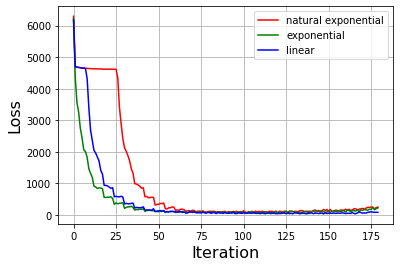

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6, 4))
ax.plot(Loss_Annealing_Model_exp, Color='red', label='natural exponential')
ax.plot(Loss_Annealing_Model_Prop, Color='green', label='exponential')
ax.plot(Loss_Annealing_Model_linear, Color='blue', label='linear')
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [ ]:
# print(Loss_Annealing_Model_exp)

[6295.4160088300705, 4698.362445831299, 4681.099160313606, 4668.512912392616, 4665.40352332592, 4649.154500126839, 4645.708291292191, 4642.8637989759445, 4642.6537890434265, 4637.786241769791, 4631.127181529999, 4630.308316707611, 4629.626549243927, 4627.073973894119, 4626.6579077243805, 4623.503995895386, 4626.226335763931, 4620.009803056717, 4612.908445119858, 4620.35947227478, 4618.407818555832, 4617.662576675415, 4618.4861171245575, 4614.872433662415, 4616.73054933548, 4614.7221603393555, 4340.615003347397, 3408.0363912582397, 2879.1572725772858, 2405.6561209112406, 2125.3465134873986, 2012.9659889303148, 1874.5371485576034, 1705.1083010323346, 1460.5514042954892, 1315.0550528094172, 990.863434761297, 975.5274964037817, 948.2394827473909, 905.2119477665983, 846.7528409359511, 858.550159299979, 573.2552340372931, 588.3645126987249, 542.1010585740441, 548.3139305345248, 558.3395072179846, 556.7611744028982, 311.01018921949435, 329.15448177506914, 336.3068705199985, 365.6474192829337,

In [ ]:
# print(Loss_Annealing_Model_Prop)

[6220.854539632797, 4357.512228369713, 3560.7143238782883, 3258.6882833838463, 2744.3019897937775, 2443.440160661936, 2063.850209519267, 2008.1231438145041, 1826.5542283058167, 1459.5433863922954, 1317.8277175985277, 1193.670773955062, 913.462082920596, 884.8907753033563, 837.7196136526763, 855.9593238416128, 849.7270208965056, 831.7540355953388, 556.6059640741441, 552.3761584348977, 561.1651882429142, 556.4671341502108, 573.4008204466663, 522.9952387192752, 334.23353291267995, 381.49829956085887, 351.4878318324336, 365.54082414496224, 372.3614286106895, 381.86965760361636, 207.0965942578623, 236.2556466513779, 254.10093355245772, 254.98677541621146, 273.9518919768743, 229.46912388467172, 151.20215218178055, 172.70516892365413, 162.72984167112736, 183.50582504263002, 173.82667379720078, 195.64218519820133, 111.94436782556295, 135.27907845918526, 145.95666329300911, 141.37535232941445, 135.83692460513703, 130.86519827920347, 123.38699456820177, 107.96427598726041, 101.59184595567785, 10

In [ ]:
# print(Loss_Annealing_Model_linear)

[6177.63513982296, 4688.154862642288, 4680.595834970474, 4679.982576608658, 4658.844668149948, 4658.0486072301865, 4656.042840242386, 4643.63847887516, 4316.2015463113785, 3397.0152685046196, 2686.084766983986, 2362.6502960920334, 2049.1474898308516, 1961.7500022128224, 1836.1954694539309, 1706.1916274949908, 1410.197340078652, 1294.495565244928, 935.8000734616071, 935.2391139315441, 917.0666223624721, 881.0626139689703, 842.8628254611976, 859.8692125482485, 572.9436194796581, 588.9477559641236, 575.0998206199147, 571.2292809489882, 590.6300078561762, 563.8484839322045, 344.9473996211309, 366.9364054800826, 351.0408669330063, 350.98355356484535, 368.0944739432307, 371.7355560786091, 217.26770937783294, 237.94814313817187, 225.6872198242927, 229.97781399221276, 226.38184007268865, 255.30620852761422, 158.13169128586014, 152.08564721266885, 156.5181927769081, 158.22156277913746, 142.7848219147927, 196.10055373955765, 101.20282580216008, 118.48277791491637, 127.64937190130513, 138.5585107